In [106]:
from sklearn.utils import murmurhash3_32
import random
import sys

random.seed(13)

def h(x, seed, R):
    return murmurhash3_32(key=x, seed=seed) % R

class CountMinSketch:
  def __init__(self, d: int, R: int):
    self.d = d
    self.R = R
    self.array = []

    for _i in range(d):
      self.array.append([0] * R)

  def insert(self, token: str):
    for i in range(self.d):
      hash = h(token, i, self.R)
      self.array[i][hash] += 1

  def query(self, token: str):
    res = []
    for i in range(self.d):
      hash = h(token, i, self.R)
      res.append(self.array[i][hash])
    return min(res)
  
  def get_memory_usage(self):
    memory = sys.getsizeof(self)
    for subarray in self.array:
      memory += sys.getsizeof(subarray)
    return memory

In [107]:
from collections import defaultdict
from Oracle import Oracle

class CountMinSketchWithOracle(CountMinSketch):

  def __init__(self, d: int, R: int, oracle: Oracle):
    super().__init__(d, R)
    self.oracle = oracle
    self.heavy_hitter_counts = defaultdict(int)

  def insert(self, token: str):
    if token in self.heavy_hitter_counts or self.oracle.predict_heavy_hitter(token) == 1:
      self.heavy_hitter_counts[token] += 1
    else:
      super().insert(token)

  def query(self, token: str):
    if token in self.heavy_hitter_counts:
      # print(self.heavy_hitter_counts)
      return self.heavy_hitter_counts[token]
    else:
      return super().query(token)
    
  def get_memory_usage(self):
    return super().get_memory_usage() + self.oracle.get_memory_usage() + sys.getsizeof(self.heavy_hitter_counts)

In [110]:
import pandas as pd

queries = []
for i in range(1, 2):
    data = pd.read_csv('data/aol/user-ct-test-collection-0' + str(i) + '.txt', sep="\t")
    queries.extend(data.Query.dropna())

In [111]:
from collections import Counter 

tokens_freq = Counter(queries)

In [112]:
print(len(tokens_freq))

1216652


In [114]:
freq_tokens = tokens_freq.most_common(100)
infreq_tokens = tokens_freq.most_common()[:-101:-1]
random_tokens = random.sample(tokens_freq.items(), 100)

/var/folders/4n/ghvzsdpj5nq5mtt0z1brxsm00000gn/T/ipykernel_79522/737723934.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_tokens = random.sample(tokens_freq.items(), 100)


In [115]:
common_tokens = tokens_freq.most_common(1000)

In [116]:
D = 4

In [118]:
sketches = [CountMinSketch(D, 2 ** R) for R in range(13, 17)]

In [119]:
for query in queries:
    for sketch in sketches:
        sketch.insert(query)

## Ideal Oracle (For Benchmarking)

In [120]:
class IdealOracle(Oracle): 
  
    def predict_heavy_hitter(self, token): 
        if token in tokens_freq and tokens_freq[token] >= 200:
            return 1
        else: 
            return 0

    def get_memory_usage(self): 
        return 0

ideal_oracle = IdealOracle()
sketches_with_oracles = [CountMinSketchWithOracle(D, 2 ** R, ideal_oracle) for R in range(13, 17)]

In [121]:
for query in queries:
    for sketch in sketches_with_oracles:
        sketch.insert(query)

## Logistic Regression

### Training The Model

In [251]:
DECISION_THRESHOLD = 0.94

In [252]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from collections import Counter 
from sklearn.utils import class_weight

In [253]:
training_data = pd.read_csv('data/aol/user-ct-test-collection-05.txt', sep="\t")
training_queries = training_data.Query.dropna()
training_tokens_freq = Counter(training_queries)

testing_data = pd.read_csv('data/aol/user-ct-test-collection-04.txt', sep="\t")
testing_queries = training_data.Query.dropna()
testing_tokens_freq = Counter(training_queries)

In [254]:
# Function to extract features
def extract_features(token):
    length = len(token)
    digits = sum(c.isdigit() for c in token)
    upper = sum(c.isupper() for c in token)
    lower = sum(c.islower() for c in token)
    special = sum(not c.isalnum() for c in token)
    entropy = -sum((token.count(c)/len(token)) * np.log2(token.count(c)/len(token)) for c in set(token))
    return [length, digits, upper, lower, special, entropy]

In [255]:
# Prepare the dataset
X_train = np.array([extract_features(token) for token, _ in training_tokens_freq.items()])
y_train = np.array([1 if freq >= 200 else 0 for _, freq in training_tokens_freq.items()])
X_test = np.array([extract_features(token) for token, _ in testing_tokens_freq.items()])
y_test = np.array([1 if freq >= 200 else 0 for _, freq in testing_tokens_freq.items()])

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

# Train the model
model = LogisticRegression(class_weight=class_weights_dict)
model.fit(X_train, y_train)

# Evaluate the model
predictions = (model.predict_proba(X_test)[:, 1] >= DECISION_THRESHOLD).astype(int)
print("Accuracy:", accuracy_score(y_test, predictions))
print("F1 Score:", f1_score(y_test, predictions))
print("Confusion Matrix:", confusion_matrix(y_test, predictions))

Accuracy: 0.9991651328559645
F1 Score: 0.03571428571428571
Confusion Matrix: [[1292519     541]
 [    539      20]]


In [256]:
import pickle

# Save model
filename = 'models/logistic_regression.sav'
pickle.dump(model, open(filename, 'wb'))

### Augmenting With CM Sketch

In [257]:
import pickle
import numpy as np

class LogisticRegressionOracle(Oracle):

    def __init__(self, model):
        self.model = model
    
    def predict_heavy_hitter(self, token: str):
        features = np.array([extract_features(token)])
        prediction = (self.model.predict_proba(features)[:, 1] >= DECISION_THRESHOLD).astype(int)
        return prediction[0]
    
    def get_memory_usage(self):
        return sys.getsizeof(pickle.dumps(self.model))

lr_model = pickle.load(open('models/logistic_regression.sav', 'rb'))
lr_oracle = LogisticRegressionOracle(lr_model)
    
lr_sketches = [CountMinSketchWithOracle(D, 2 ** R, lr_oracle) for R in range(13, 17)]

In [258]:
for query in queries:
    for sketch in lr_sketches:
        sketch.insert(query)

In [259]:
from statistics import mean, median

def get_error_statistics(sketch, token_counts):
    errors = []
    for token, actual_count in token_counts:
        estimated_count = sketch.query(token)
        errors.append(abs(estimated_count - actual_count))
    return mean(errors), median(errors)

In [260]:
# print("Min Sketch")
# errors = get_error_statistics(sketch, tokens_freq.items())
# print("Mean error:", errors[0])
# print("Median error:", errors[1])
# print("Memory usage:", str(sketch.get_memory_usage() / (10 ** 6)), "MB")
# print()

# print("Min Sketch With Perfect Oracle")
# errors = get_error_statistics(sketch_with_oracle, tokens_freq.items())
# print("Mean error:", errors[0])
# print("Median error:", errors[1])
# print("Memory usage:", str(sketch_with_oracle.get_memory_usage() / (10 ** 6)), "MB")

In [261]:
# import matplotlib.pyplot as plt

# def plot_errors(sketch, sketch_with_oracle, token_counts, title=""):

#   min_sketch_errors = []
#   sketch_with_oracle_errors = []

#   for token, actual_count in token_counts:
#     estimated_count = sketch.query(token)
#     min_sketch_errors.append(abs(estimated_count - actual_count)/actual_count)

#     estimated_count = sketch_with_oracle.query(token)
#     sketch_with_oracle_errors.append(abs(estimated_count - actual_count)/actual_count)

#   plt.plot(min_sketch_errors, label = "Count Min Sketch")
#   plt.plot(sketch_with_oracle_errors, label = "Count Min Sketch With Oracle")
#   plt.xlabel("Token")
#   plt.ylabel("Error")
#   plt.title(title)
#   plt.legend()
#   plt.show()

In [262]:
# plot_errors(sketch, sketch_with_oracle, freq_tokens, "Error For Most Frequent Words")
# plot_errors(sketch, sketch_with_oracle, infreq_tokens, "Error For Most Infrequent Words")
# plot_errors(sketch, sketch_with_oracle, random_tokens, "Error For Random Words")

In [263]:
def calculate_error_vs_memory(sketches, sketches_with_oracle, lr_sketches, token_counts, title=""):

  min_sketch_errors = []
  min_sketch_memory = []
  sketch_with_oracle_errors = []
  sketch_with_oracle_memory = []
  lr_sketch_errors = []
  lr_sketch_memory = []

  for sketch in sketches:
    min_sketch_errors.append(get_error_statistics(sketch, token_counts)[0])
    min_sketch_memory.append(sketch.get_memory_usage())

  for sketch in sketches_with_oracle:
    sketch_with_oracle_errors.append(get_error_statistics(sketch, token_counts)[0])
    sketch_with_oracle_memory.append(sketch.get_memory_usage())

  for sketch in lr_sketches:
    lr_sketch_errors.append(get_error_statistics(sketch, token_counts)[0])
    lr_sketch_memory.append(sketch.get_memory_usage())

  return min_sketch_errors, min_sketch_memory, sketch_with_oracle_errors, sketch_with_oracle_memory, lr_sketch_errors, lr_sketch_memory

In [264]:
min_sketch_errors, min_sketch_memory, sketch_with_oracle_errors, sketch_with_oracle_memory, lr_sketch_errors, lr_sketch_memory = calculate_error_vs_memory(sketches, sketches_with_oracles, lr_sketches, common_tokens)

In [265]:
print(min_sketch_errors)
print(min_sketch_memory)
print(sketch_with_oracle_errors)
print(sketch_with_oracle_memory)
print(lr_sketch_errors)
print(lr_sketch_memory)

[310.075, 144.442, 65.006, 27.67]
[262416, 524560, 1048848, 2097424]
[146.828, 68.592, 31.038, 13.212]
[280944, 543088, 1067376, 2115952]
[300.254, 139.851, 62.92, 26.728]
[281823, 543967, 1068255, 2116831]


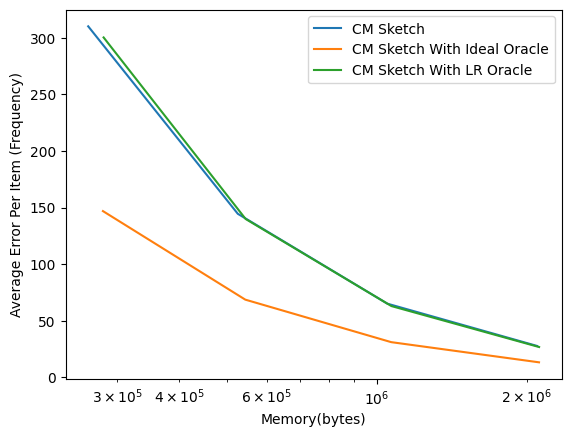

In [270]:
import matplotlib.pyplot as plt

plt.xscale("log")
plt.plot(min_sketch_memory, min_sketch_errors, label = "CM Sketch")
plt.plot(sketch_with_oracle_memory, sketch_with_oracle_errors, label = "CM Sketch With Ideal Oracle")
plt.plot(lr_sketch_memory, lr_sketch_errors, label = "CM Sketch With LR Oracle")
plt.xlabel("Memory(bytes)")
plt.ylabel("Average Error Per Item (Frequency)")
plt.legend()
plt.show()